**Reference**: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder . Chapter 17 of Geron's book.

This file trains an autoencoder with the instances of the normal digit in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digit in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model
# import cv2

### **Loading the MNIST data and forming arrays of the normal training data, validation data (normal and abnormal, and the test data (normal and abnormal)**

In [2]:
nl1 = 4   # Normal digit 1
nl2 = 6   # Normal digit 2
abn = 8

(x_train_0, y_train_0), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train_0 = x_train_0.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

train_size = x_train_0.shape[0] * 9 // 10

x_train, x_valid, y_train, y_valid = train_test_split(x_train_0, y_train_0, train_size = train_size)

normal_data = x_train[(y_train == nl1) | (y_train == nl2)]    # Normal training data (Normal digits)
normal_labels = y_train[(y_train == nl1) | (y_train == nl2)]  

valid_data = x_valid[(y_valid == abn) | (y_valid == nl1) | (y_valid == nl2)]    # Validation data (both normal digits and the abnormal digit)
valid_labels = y_valid[(y_valid == abn) | (y_valid == nl1) | (y_valid == nl2)]

test_data = x_test[(y_test == abn) | (y_test == nl1) | (y_test == nl2)]   # Test data (both normal digits and the abnormal digit)
test_labels = y_test[(y_test == abn) | (y_test == nl1) | (y_test == nl2)]

test_labels_T_F = np.where((test_labels == nl1) | (test_labels == nl2), True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

valid_labels_T_F = np.where((valid_labels == nl1) | (valid_labels == nl2), True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
normal_data.shape, normal_labels.shape, valid_data.shape, valid_labels.shape, test_data.shape, test_labels.shape

((10567, 28, 28), (10567,), (1792, 28, 28), (1792,), (2914, 28, 28), (2914,))

In [4]:
normal_test_data = test_data[(test_labels == nl1) | (test_labels == nl2)]   # The normal digits in the test data
abnormal_test_data = test_data[test_labels == abn]                          # The abnormal digits in the test data
normal_test_labels = test_labels[(test_labels == nl1) | (test_labels == nl2)]   # Their labels
abnormal_test_labels = test_labels[test_labels == abn]                          # Their labels

In [5]:
normal_test_data.shape, abnormal_test_data.shape

((1940, 28, 28), (974, 28, 28))

In [6]:
normal_valid_data = valid_data[(valid_labels == nl1) | (valid_labels == nl2)]   # The normal digits in the valid data
abnormal_valid_data = valid_data[valid_labels == abn]                           # The abnormal digits in the valid data
normal_valid_labels = valid_labels[(valid_labels == nl1) | (valid_labels == nl2)]   # Their labels
abnormal_valid_labels = valid_labels[valid_labels == abn]                           # Their labels

In [7]:
normal_valid_data.shape, abnormal_valid_data.shape

((1193, 28, 28), (599, 28, 28))

### **Building and training the network** 

In [8]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(256, activation="selu"),
      layers.Dense(128, activation="selu"),
      layers.Dense(64, activation="selu"),
      layers.Dense(16, activation="selu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="selu"),                                  
      layers.Dense(128, activation="selu"),
      layers.Dense(256, activation="selu"),
      layers.Dense(28*28, activation="sigmoid"),
      layers.Reshape((28, 28))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [9]:
# autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [10]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("AE_model", monitor="val_loss", save_best_only=True)

history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=128,
          validation_data=(normal_valid_data, normal_valid_data),
          callbacks=[checkpoint_cb],
          shuffle=True)

Epoch 1/100
83/83 [==============================] - 11s 51ms/step - loss: 0.2307 - val_loss: 0.1755
Epoch 2/100
83/83 [==============================] - 2s 20ms/step - loss: 0.1634 - val_loss: 0.1588
Epoch 3/100
83/83 [==============================] - 2s 20ms/step - loss: 0.1453 - val_loss: 0.1414
Epoch 4/100
83/83 [==============================] - 2s 23ms/step - loss: 0.1349 - val_loss: 0.1311
Epoch 5/100
83/83 [==============================] - 2s 21ms/step - loss: 0.1284 - val_loss: 0.1255
Epoch 6/100
83/83 [==============================] - 2s 21ms/step - loss: 0.1241 - val_loss: 0.1220
Epoch 7/100
83/83 [==============================] - 2s 23ms/step - loss: 0.1203 - val_loss: 0.1173
Epoch 8/100
83/83 [==============================] - 2s 20ms/step - loss: 0.1176 - val_loss: 0.1167
Epoch 9/100
83/83 [==============================] - 2s 20ms/step - loss: 0.1152 - val_loss: 0.1140
Epoch 10/100
83/83 [==============================] - 2s 23ms/step - loss: 0.1130 - val_loss: 0.111

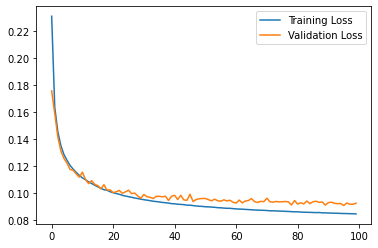

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [12]:
model = autoencoder
model.summary(expand_nested=True, show_trainable=True)

Model: "anomaly_detector"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential (Sequential)     (None, 16)                243152    Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| flatten (Flatten)         (None, 784)               0         Y          |
|                                                                          |
| dense (Dense)             (None, 256)               200960    Y          |
|                                                                          |
| dense_1 (Dense)           (None, 128)               32896     Y          |
|                                                                          |
| dense_2 (Dense)           (None, 64)                8256      Y          |
|                                                                          |
| dense_3 (Dense)           (None, 16)            

In [13]:
model_encoder = autoencoder.encoder
# model_encoder.summary(expand_nested=True, show_trainable=True)

In [14]:
model_decoder = autoencoder.decoder
# model_decoder.summary(expand_nested=True, show_trainable=True)

In [15]:
model_layers = np.array(model.layers)
n_layers = model_layers.shape[0] 
# np.concatenate((np.arange(n_layers).reshape(n_layers,1), model_layers.reshape(n_layers,1)), axis = 1)

### **The original and reconstructed images for the first 30 instances of the normal training data, validation data, normal validation data, abnormal validation data, test data, normal test data, and abnormal test data**

In [16]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [17]:
def show_reconstructions(autoencoder, images, n_images=5):
    encoded_data = autoencoder.encoder(images[:n_images]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    reconstructions = decoded_data
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

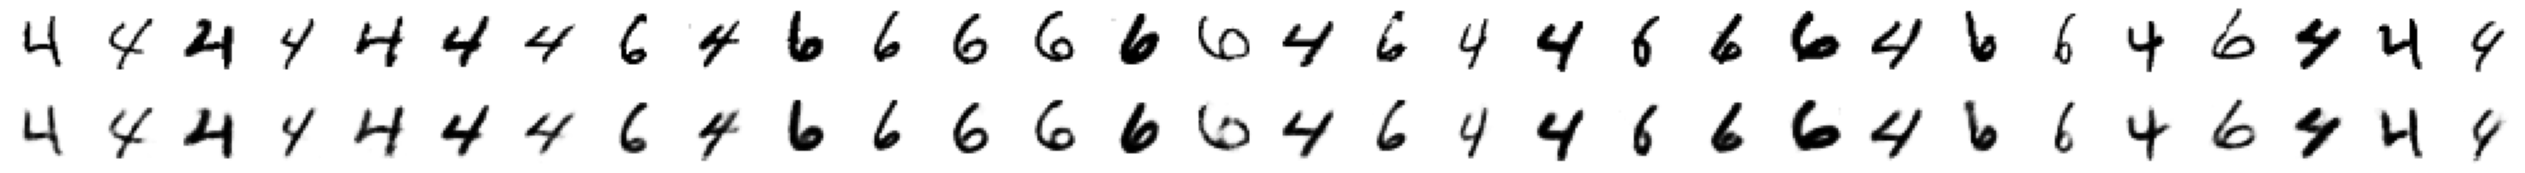

In [18]:
show_reconstructions(autoencoder, normal_data, 30)
plt.show()

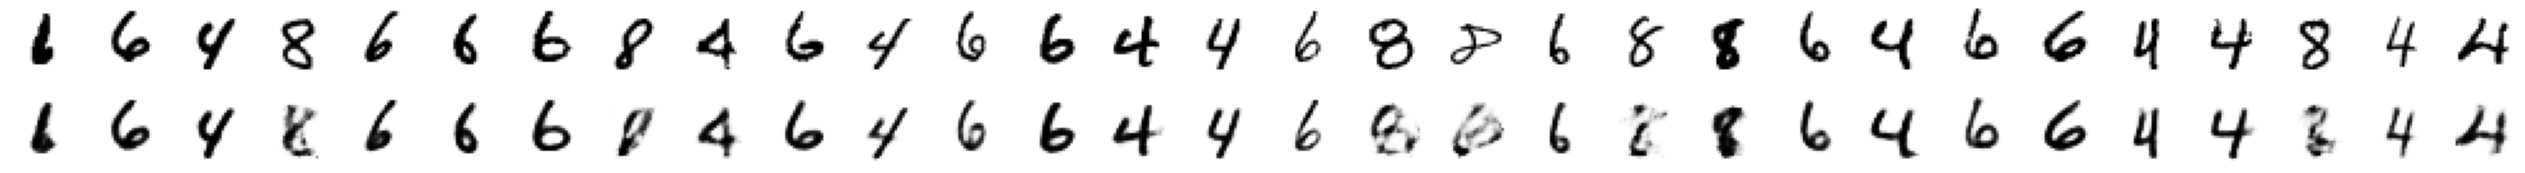

In [19]:
show_reconstructions(autoencoder, valid_data, 30)
plt.show()

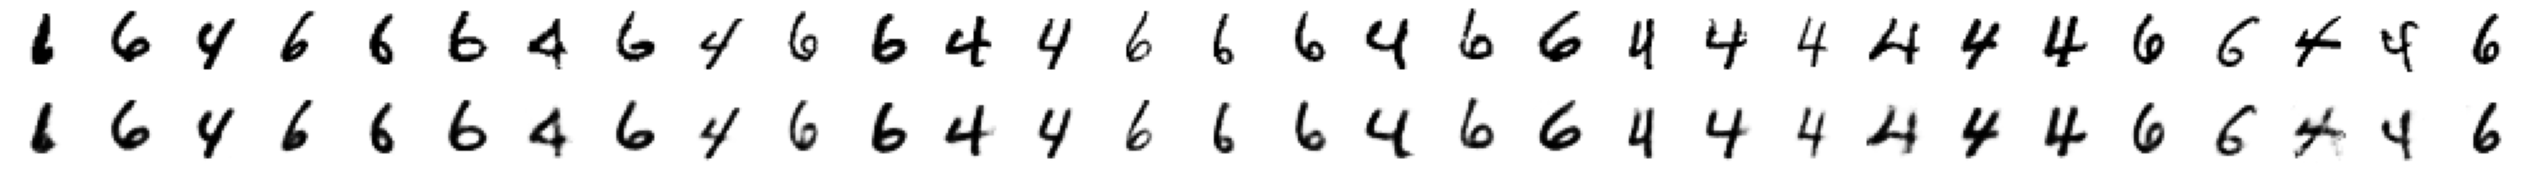

In [20]:
show_reconstructions(autoencoder, normal_valid_data, 30)
plt.show()

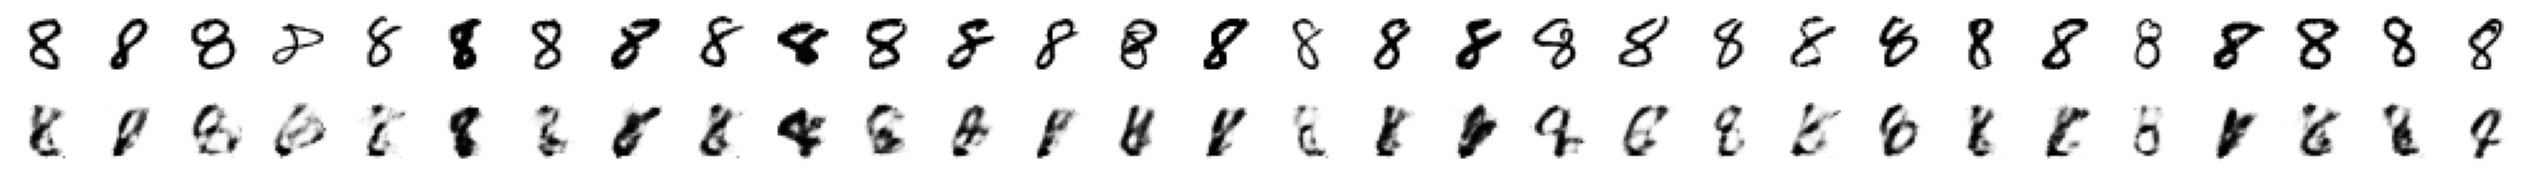

In [21]:
show_reconstructions(autoencoder, abnormal_valid_data, 30)
plt.show()

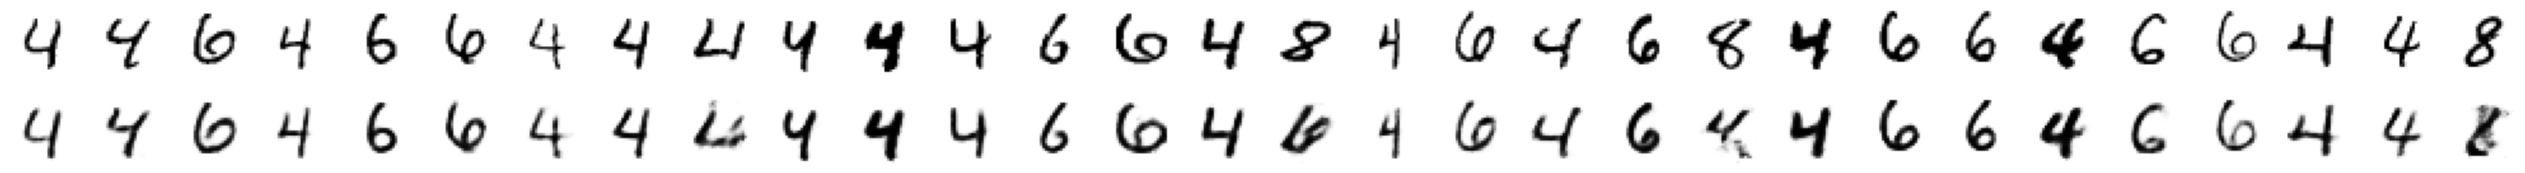

In [22]:
show_reconstructions(autoencoder, test_data, 30)
plt.show()

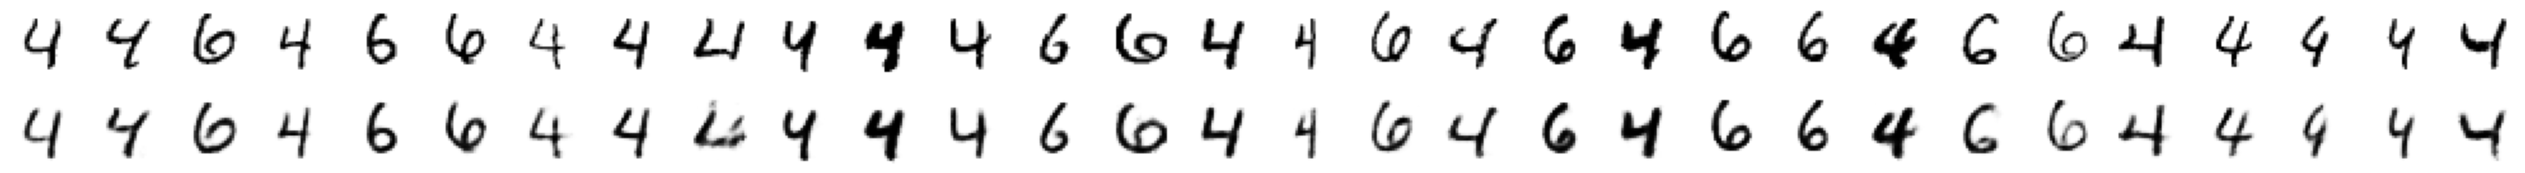

In [23]:
show_reconstructions(autoencoder, normal_test_data, 30)
plt.show()

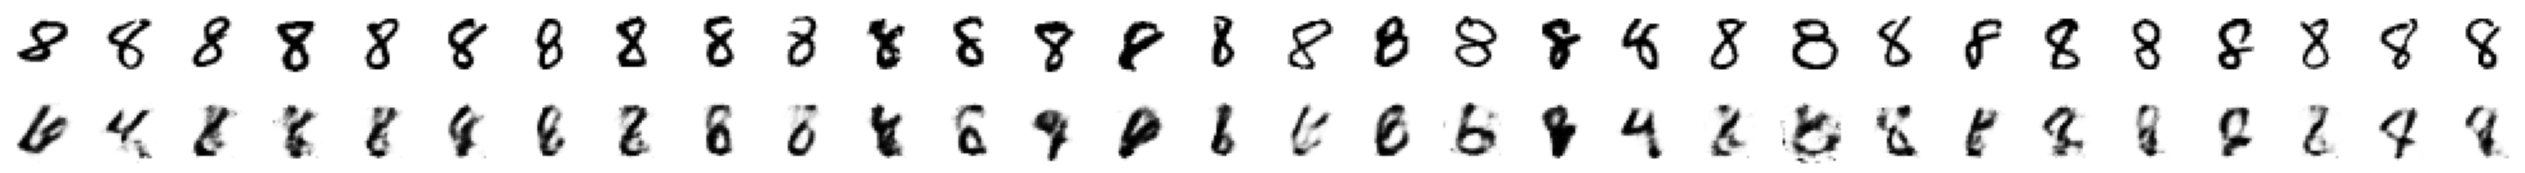

In [24]:
show_reconstructions(autoencoder, abnormal_test_data, 30)
plt.show()

In [25]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

**1-Dim plot of pixels of the first normal test data**

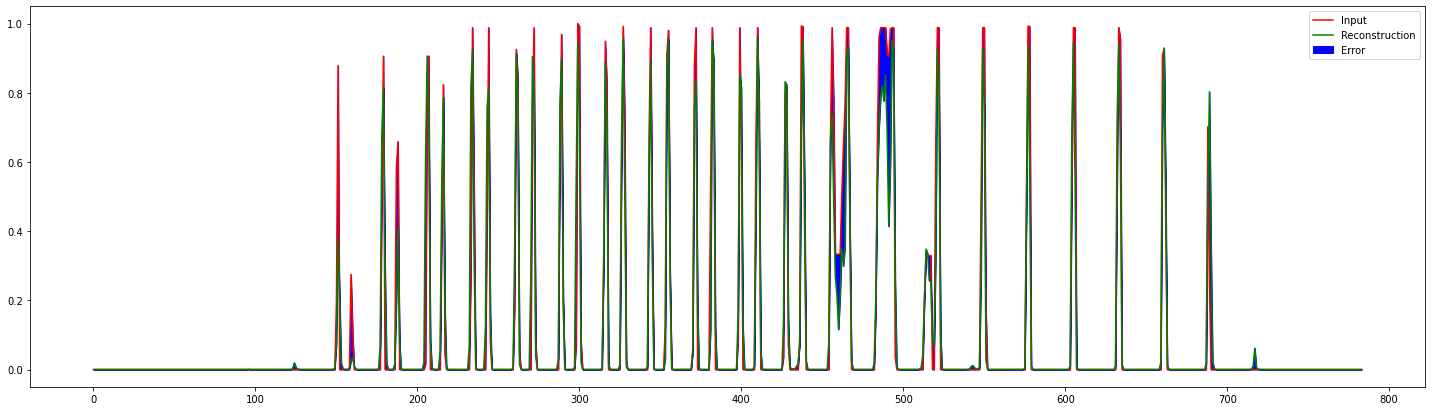

In [26]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [27]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

**1-Dim plot of pixels of the first abnormal test data**

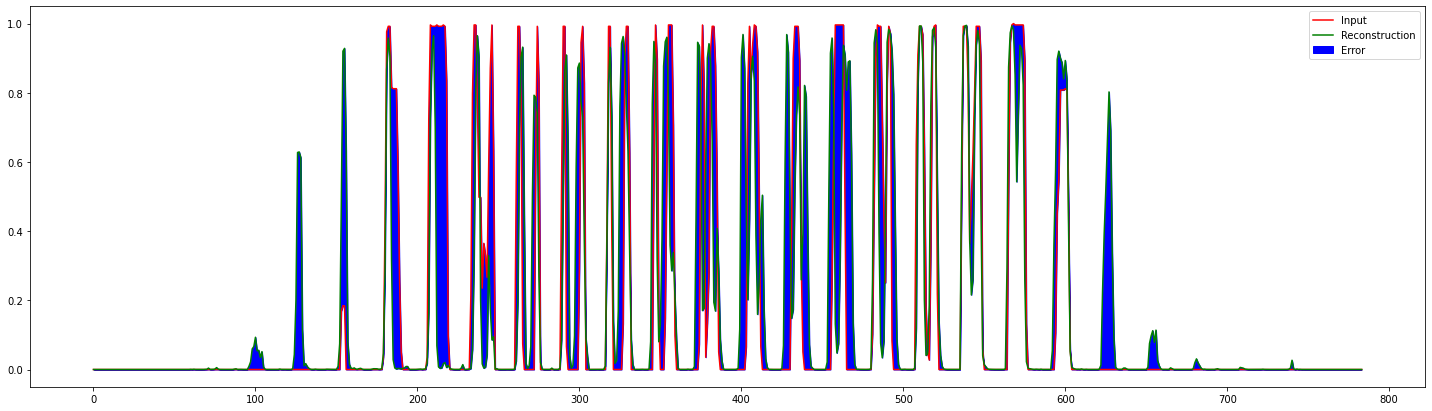

In [28]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### **Distributions of the reconstruction losses and the calculation of the threshold.**

**Distribution of the reconstruction losses of the normal training data**



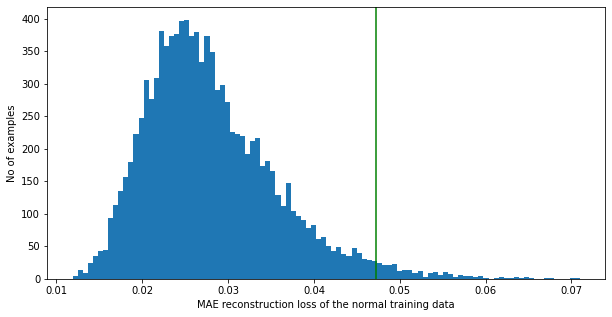

In [29]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.figure(figsize=(10,5))
plt.hist(train_loss[None,:], bins=100)
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the normal training data")
plt.ylabel("No of examples")
plt.show()

In [30]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.02802968
Std:  0.007666865


In [31]:
threshold_train_mean_2_5_std = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std: ", threshold_train_mean_2_5_std)

Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std:  0.047196842497214675


In [32]:
threshold1 = threshold_train_mean_2_5_std

**Distribution of the reconstruction losses of the abnormal validation data**



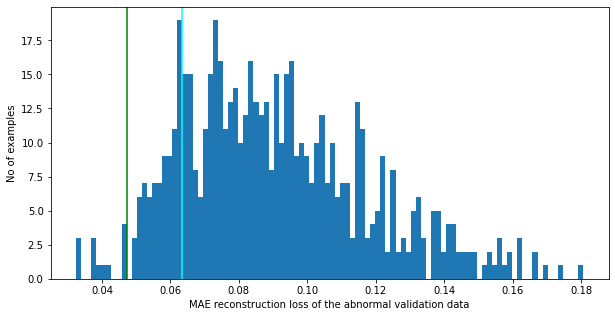

In [33]:
reconstructions = autoencoder.predict(abnormal_valid_data)
abn_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(abn_valid_loss[None, :], bins=100)
threshold2 = np.mean(abn_valid_loss) - np.std(abn_valid_loss)
plt.axvline(threshold2,c='cyan')
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the abnormal validation data")
plt.ylabel("No of examples")
plt.show()

In [34]:
abnormal_valid_mean_loss = np.mean(abn_valid_loss)

In [35]:
abnormal_valid_mean_loss , np.std(abn_valid_loss)

(0.09062197, 0.027259082)

In [36]:
threshold2 = abnormal_valid_mean_loss - np.std(abn_valid_loss)
print("Threshold2: ", threshold2)

Threshold2:  0.06336289


**Distribution of the reconstruction losses of the normal validation data**

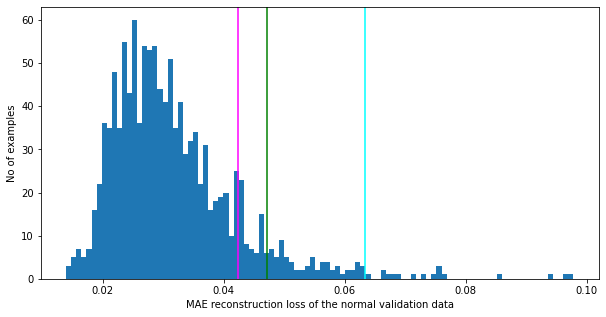

In [37]:
reconstructions = autoencoder.predict(normal_valid_data)
nl_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(nl_valid_loss[None, :], bins=100)
threshold3 = np.mean(nl_valid_loss) + np.std(nl_valid_loss)
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold1, c='g')
plt.xlabel("MAE reconstruction loss of the normal validation data")
plt.ylabel("No of examples")
plt.show()

In [38]:
normal_valid_mean_loss = np.mean(nl_valid_loss)

In [39]:
normal_valid_mean_loss , np.std(nl_valid_loss)

(0.031681478, 0.010576129)

In [40]:
threshold3 = normal_valid_mean_loss + np.std(nl_valid_loss)
print("Threshold3: ", threshold3)

Threshold3:  0.042257607


**Calculation of a preliminary threshold based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)**

In [41]:
Avg_of_threshold_2_3 = (threshold2 + threshold3)/2
print("Average of threshold 2 and 3: ", Avg_of_threshold_2_3)

Average of threshold 2 and 3:  0.052810247987508774


In [42]:
threshold4 = Avg_of_threshold_2_3

### **Calculation of the threshold that gives the best accuracy on the validation data and set this as the threshold.**

In [43]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

In [44]:
increment = (abnormal_valid_mean_loss- normal_valid_mean_loss)/100
thresholds = np.arange(normal_valid_mean_loss, abnormal_valid_mean_loss, increment)
thrs_size = thresholds.shape[0]
accuracies = np.zeros(thrs_size)
for i in range(thrs_size):
  preds = predict(autoencoder, valid_data, thresholds[i])
  accuracies[i] = accuracy_score(preds, valid_labels_T_F)
argmax = np.argmax(accuracies)
valid_data_best_threshold = thresholds[argmax]
print("The best threshold based on validation data: ", valid_data_best_threshold)

The best threshold based on validation data:  0.0523106504231691


In [45]:
thr_acc = np.zeros((thrs_size, 2))
thr_acc[:, 0] = thresholds
thr_acc[:, 1] = accuracies
thr_acc[argmax-2:argmax+3]

array([[0.05113184, 0.95591518],
       [0.05172125, 0.95647321],
       [0.05231065, 0.95703125],
       [0.05290006, 0.95479911],
       [0.05348946, 0.95479911]])

In [46]:
threshold5 = valid_data_best_threshold

In [47]:
threshold = threshold5

#### **Distribution of the reconstruction losses of all the validation data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

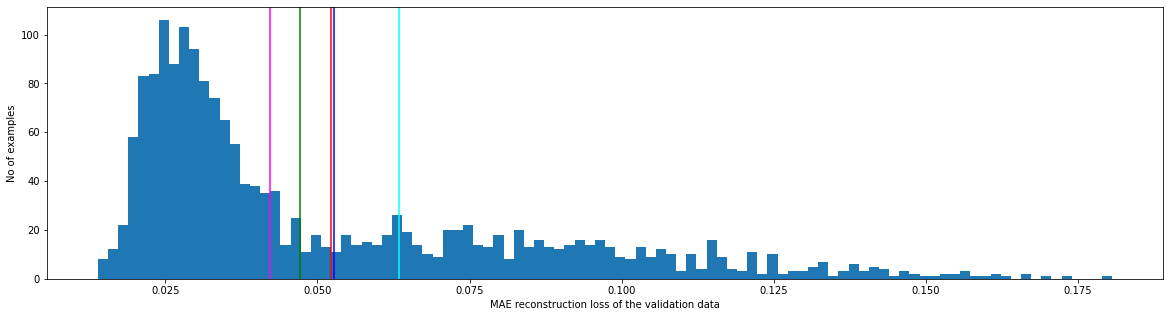

In [48]:
reconstructions = autoencoder.predict(valid_data)
valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), valid_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(valid_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the validation data")
plt.ylabel("No of examples")
plt.show()

#### **Distribution of the reconstruction losses of the test data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

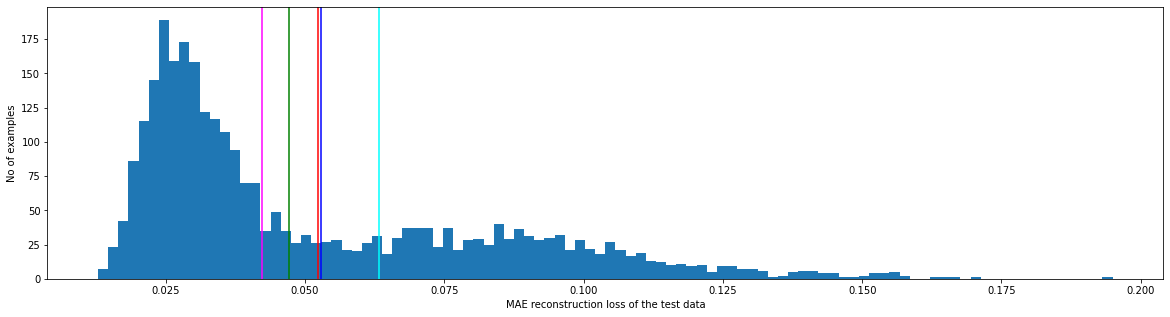

In [49]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(test_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the test data")
plt.ylabel("No of examples")
plt.show()

In [50]:
reconstructions = autoencoder.predict(normal_test_data)
nl_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_test_data.reshape(-1,784))
np.mean(nl_test_loss) , np.std(nl_test_loss)

(0.031783424, 0.010517437)

In [51]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.089906305, 0.02374103)

### **Calculation of the accuracy and the confusion matrix on the test data with threshold set based on the best threshold from the validation data**

In [52]:
# def predict(model, data, threshold):
#  reconstructions = model.predict(data)
#  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
#  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Normal Test Data Mean = {}".format(np.mean(nl_test_loss)))
  print("Normal Test Data Standard Deviation = {}".format(np.std(nl_test_loss)))
  print("Abnormal Test Data Mean = {}".format(np.mean(abn_test_loss)))
  print("Abnormal Test Data Standard Deviation = {}".format(np.std(abn_test_loss)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [53]:
preds = predict(autoencoder, test_data, valid_data_best_threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1041   1873
 label: F   [[945   29]    974
        T    [96   1844]]   1940
Accuracy = 0.9571036376115305
Normal Test Data Mean = 0.03178342431783676
Normal Test Data Standard Deviation = 0.010517437011003494
Abnormal Test Data Mean = 0.08990630507469177
Abnormal Test Data Standard Deviation = 0.02374102920293808
Precision = 0.984516817939135
Recall = 0.9505154639175257


In [62]:
print("Threshold =", valid_data_best_threshold)

Threshold = 0.0523106504231691


In [54]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 945   29]
 [  96 1844]]


#### **Extra accuracy info**
**Just informative. Please record the above accuracy.**

#### Accuracy on the test data with threshold set based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)

In [55]:
preds = predict(autoencoder, test_data, Avg_of_threshold_2_3)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1034   1880
 label: F   [[944   30]    974
        T    [90   1850]]   1940
Accuracy = 0.9588194921070693
Normal Test Data Mean = 0.03178342431783676
Normal Test Data Standard Deviation = 0.010517437011003494
Abnormal Test Data Mean = 0.08990630507469177
Abnormal Test Data Standard Deviation = 0.02374102920293808
Precision = 0.9840425531914894
Recall = 0.9536082474226805


#### Accuracy on the test data with threshold set based on the mean of the training data MAE reconstruction losses + 2.5 std

In [56]:
preds = predict(autoencoder, test_data, threshold_train_mean_2_5_std)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1125   1789
 label: F   [[961   13]    974
        T    [164   1776]]   1940
Accuracy = 0.9392587508579272
Normal Test Data Mean = 0.03178342431783676
Normal Test Data Standard Deviation = 0.010517437011003494
Abnormal Test Data Mean = 0.08990630507469177
Abnormal Test Data Standard Deviation = 0.02374102920293808
Precision = 0.9927333705980995
Recall = 0.9154639175257732
